In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### 데이터셋 출처
- instacart
- https://www.instacart.com/

In [2]:
path = 'C:/Users/Shiwon Kim/0_ML/test5'
opp = pd.read_csv(path + '/' + 'order_products__prior.csv')
orders = pd.read_csv(path + '/' + 'orders.csv')
products = pd.read_csv(path + '/' + 'products.csv')

In [3]:
print(opp.shape)
print(orders.shape)
print(products.shape)

(32434489, 4)
(3421083, 7)
(49688, 4)


#### 추천의 연결고리가 모호한 데이터
- 데이터의 특성을 확인한 후 연결고리 패턴을 고민
- 앞선 데이터는 확실한 연결고리인 rating이 있었다면 이번 데이터는 추천의 연결고리가 모호

In [4]:
opp.head()

# order_id: 주문 번호(하나의 주문에 여러 상품 동시에 포함 가능)
# product_id: 상품 번호
# add_to_cart_order: 장바구니에 담은 순서
# reordered: 재구매 여부(1: yes, 0: no)

# 순서 정보 -> 가장 처음으로 구매하는 상품에 대한 예측/추천 가능
# 어떤 상품을 구매했을 때, 그 다음으로 어떤 상품을 구매하는지 파악 가능

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
orders.head()

# order_id: 주문 번호
# user_id: 회원 번호
# eval_set: 평가 데이터셋 -> 해당 row를 평가하는 데이터셋
# order_number: user_id별 누적 주문 수 -> 해당 고객이 몇 번째로 주문했는지
# order_dow: 주문 요일(day of week) -> 요일별로 자주 판매되는 상품
# order_hour_of_day: 주문 시간 -> 오전/저녁 주문의 차이를 파악, 성별/직업군 예측
# days_since_prior_order: 지난 주문 이후 얼마만에 주문했는지(주문의 주기성)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
products.head()

# product_id: 상품 번호
# product_name: 상품명
# aisle_id: 과일, 채소 등의 세부 분류(소분류)
# department_id: 과일, 채소 등(대분류)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### 주요 고려사항
- data understanding & data preparation
- 물건을 하나씩 따로 구매하기보다 장바구니에 담아서 일괄 계산하는 소비 패턴
    - opp 데이터에서 product_id(물건)는 특정 order_id(장바구니)에 포함된 상품을 의미
    - opp와 orders를 합쳐서 어떤 고객이 어떤 상품을 구매했는지 보여주는 데이터 생성

In [7]:
# 앞선 데이터들은 아래와 같이 추천의 대상과 연결고리가 명확

# 1) user <- (ratings) -> movies
# 2) user <- (ratings) -> books

# 이번 데이터는 연결고리에 대한 포괄적/세부적인 고민 필요
# 큰 틀에서 시작하여 세부적인 관점으로 좁히는 것이 유리

In [8]:
# orders -> order_id, user_id
# opp -> order_id, product_id

# 공통분모 order_id로 orders, opp 데이터를 합치면 user와 product의 관계 성립
# 어떤 고객이 어떤 상품을 구매했는지에 대한 정보

# opp에 이미 3천만 건의 데이터가 존재하므로 products는 굳이 사용하지 x
# 데이터를 모두 사용하지 않고 필요한 데이터만 골라서 사용하는 것이 중요

# products에서 상품명을 바로 확인할 수 있다는 장점이 있지만,
# 그러지 않아도 분석 후에 opp의 product_id 컬럼을 products에 매핑하여 쉽게 조회 가능

In [9]:
combined = pd.merge(opp, orders)
combined

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0


In [10]:
combined['count'] = 1
group_agg = combined.groupby(['product_id', 'user_id']).agg({'count':np.sum}).reset_index()
group_agg

# product_id가 A인 상품을 B 고객이 몇 번 구매했는지 확인 -> 어떤 고객이 어떤 상품을 얼마나 구매했는지
# ex) product_id가 1인 물건을 user_id가 138인 고객이 2번 구매

,product_id,user_id,count
0,1,138,2
1,1,709,1
2,1,764,2
3,1,777,1
4,1,825,1
...,...,...,...
13307948,49688,197371,1
13307949,49688,200215,1
13307950,49688,200377,1
13307951,49688,200873,2


In [11]:
# 재구매 여부 -> 위의 count 컬럼에 -1한 값 출력
combined.groupby(['product_id', 'user_id']).agg({'reordered':np.sum}).reset_index()

,product_id,user_id,reordered
0,1,138,1
1,1,709,0
2,1,764,1
3,1,777,0
4,1,825,0
...,...,...,...
13307948,49688,197371,0
13307949,49688,200215,0
13307950,49688,200377,0
13307951,49688,200873,1


In [ ]:
pvt = group_agg.pivot_table(index='user_id', columns='product_id', values='count').fillna(0)
pvt.head()

# 데이터가 너무 많아 out of bounds IndexError 발생 -> filtering 필요

#### Filtering
- 의사결정/추천에 기여하지 못하는 데이터를 제외
- 잘 팔리는 상품, 구매 이력이 많은 고객을 추출

In [13]:
print(len(set(group_agg['product_id']))) # 상품의 개수
print(len(set(group_agg['user_id']))) # 고객의 수

49677
206209


In [14]:
# item 기준으로 확인
prod_cnt = group_agg.groupby('product_id').agg({'count':np.sum}).reset_index()
prod_cnt.sort_values(by='count')

# count=1 -> 안 팔린 상품

,product_id,count
14752,14756,1
23649,23653,1
45264,45273,1
47669,47680,1
23620,23624,1
...,...,...
47198,47209,213584
21899,21903,241921
21133,21137,264683
13172,13176,379450


<AxesSubplot:>

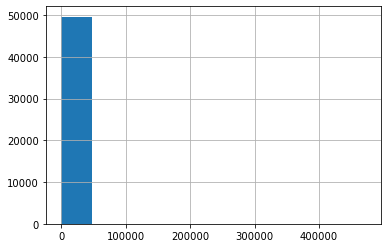

In [15]:
prod_cnt['count'].hist()

# 약 5만 개의 데이터 중 대부분이 팔리지 않은 상품 -> 파레토 분포

<AxesSubplot:>

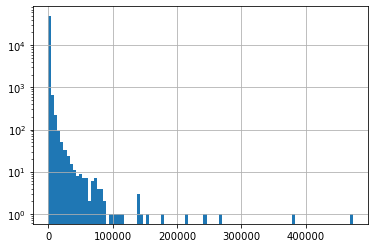

In [16]:
prod_cnt['count'].hist(bins=100, log=True)

# 대부분의 상품이 1~3번 정도 밖에 팔리지 않았으므로 best seller 상품을 찾아 조회

In [17]:
print(len(prod_cnt.loc[prod_cnt['count'] <= 10]))
print(len(prod_cnt.loc[prod_cnt['count'] <= 100]))

# 총 5만 개의 데이터 중 열 번 이하의 선택을 받은 상품이 8천 개 정도
# 백 번 이하의 선택을 받은 상품은 3만 개 정도 -> 100회를 filtering 기준으로 설정

7995
29698


In [18]:
# user 기준으로 확인
user_cnt = group_agg.groupby('user_id').agg({'count':np.sum}).reset_index()
user_cnt.sort_values(by='count')

,user_id,count
166063,166064,3
34193,34194,3
124118,124119,3
173245,173246,3
168360,168361,3
...,...,...
176477,176478,2921
186703,186704,2936
164054,164055,3061
129927,129928,3638


<AxesSubplot:>

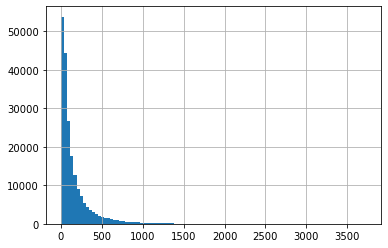

In [19]:
user_cnt['count'].hist(bins=100)

# product에 비해 큰 값과 작은 값의 차이가 덜하지만 여전히 파레토 분포

<AxesSubplot:>

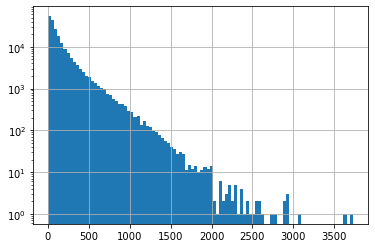

In [20]:
user_cnt['count'].hist(bins=100, log=True)

In [21]:
len(user_cnt.loc[user_cnt['count'] <= 100])

# 도메인 특성 상 생필품, 농수산물(식품) 등 구매가 잦은 상품이 존재하므로,
# 처음부터 필터링 기준을 100회로 movies, books 데이터에 비해 높게 설정
# movies, books는 주기적으로 반드시 살 필요가 없는 상품

116101

In [22]:
# 인기 상품, 헤비 유저 추출
pop_prods = set(prod_cnt.loc[prod_cnt['count'] > 100]['product_id'])
heavy_user = set(user_cnt.loc[user_cnt['count'] > 100]['user_id'])

In [23]:
p_filter = group_agg.loc[group_agg['product_id'].isin(pop_prods)]
filtered = p_filter.loc[p_filter['user_id'].isin(heavy_user)]
filtered

# filtered: 선택을 많이 받은 상품과 매장 이용률이 높은 고객의 데이터

,product_id,user_id,count
0,1,138,2
1,1,709,1
3,1,777,1
8,1,1480,3
9,1,1494,3
...,...,...,...
13307865,49686,172636,1
13307866,49686,174261,16
13307869,49686,181321,1
13307870,49686,190576,25


In [ ]:
pvt = filtered.pivot_table(index='user_id', columns='product_id', values='count').fillna(0)
pvt.head()

# 과부하가 되어 MemoryError 발생하는 경우 -> RAM 16GB 이상 필요

In [25]:
# MemoryError 발생하지 않도록 500회로 필터링 기준 강화
pop_prods = set(prod_cnt.loc[prod_cnt['count'] > 500]['product_id'])
heavy_user = set(user_cnt.loc[user_cnt['count'] > 500]['user_id'])

p_filter = group_agg.loc[group_agg['product_id'].isin(pop_prods)]
filtered = p_filter.loc[p_filter['user_id'].isin(heavy_user)]
filtered

,product_id,user_id,count
30,1,8703,1
76,1,17671,1
79,1,18631,1
88,1,21219,1
190,1,51601,1
...,...,...,...
13307730,49683,205898,1
13307754,49683,206035,1
13307763,49683,206079,1
13307765,49683,206083,4


In [26]:
pvt = filtered.pivot_table(index='user_id', columns='product_id', values='count').fillna(0)
pvt.head()

product_id,1,10,23,25,28,32,34,37,45,49,...,49622,49628,49630,49640,49644,49652,49655,49667,49680,49683
user_id,,,,,,,,,,,,,,,,,,,,,
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
item_corr = pvt.corr() # 20분 이상 소요
item_corr.head()

product_id,1,10,23,25,28,32,34,37,45,49,...,49622,49628,49630,49640,49644,49652,49655,49667,49680,49683
product_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.002699,-0.002693,-0.002203,-0.001227,-0.001245,-0.004087,-0.001187,-0.006642,-0.002777,...,-0.001250,-0.003758,-0.001207,-0.001649,-0.001225,-0.002637,-0.002223,-0.001916,-0.002129,-0.006097
10,-0.002699,1.000000,-0.004261,0.010517,-0.002832,-0.002875,0.031527,0.002485,-0.006950,-0.003578,...,0.000820,0.034354,-0.002787,0.000019,-0.001819,-0.002743,0.001233,-0.003218,0.000724,-0.008682
23,-0.002693,-0.004261,1.000000,-0.002611,-0.001977,-0.002869,0.004384,-0.002734,0.015304,-0.005249,...,-0.002879,0.000008,-0.002782,-0.003199,-0.002822,0.002060,-0.002909,-0.004414,-0.001094,0.014445
25,-0.002203,0.010517,-0.002611,1.000000,0.004813,-0.002347,0.010990,-0.002236,-0.005737,-0.004877,...,0.007336,0.012692,-0.002276,0.010420,0.000996,-0.004969,-0.000295,-0.003611,-0.001408,-0.008681
28,-0.001227,-0.002832,-0.001977,0.004813,1.000000,-0.001307,0.021971,0.005558,-0.004426,-0.002504,...,0.072170,0.001736,0.033770,-0.001731,0.005724,-0.002767,0.032396,-0.001114,-0.002234,0.001844


#### 비율(ratio) 관점의 연결고리
- 전체 방문횟수 대비 실제 구매횟수의 비율

In [28]:
orders['user_id']

0               1
1               1
2               1
3               1
4               1
            ...  
3421078    206209
3421079    206209
3421080    206209
3421081    206209
3421082    206209
Name: user_id, Length: 3421083, dtype: int64

In [29]:
# 고객별 방문 횟수
orders['user_id'].value_counts()

152340    100
185641    100
185524    100
81678     100
70922     100
         ... 
13046       4
70208       4
111440      4
31762       4
47980       4
Name: user_id, Length: 206209, dtype: int64

In [30]:
user_counts = pd.DataFrame(orders['user_id'].value_counts().reset_index())
user_counts.columns = ['user_id', 'user_freq']
user_counts

,user_id,user_freq
0,152340,100
1,185641,100
2,185524,100
3,81678,100
4,70922,100
...,...,...
206204,13046,4
206205,70208,4
206206,111440,4
206207,31762,4


In [31]:
# 전체 방문횟수 대비 실제 구매의 비율
# group_agg = combined.groupby(['product_id', 'user_id']).agg({'count':np.sum}).reset_index()
gu = pd.merge(group_agg, user_counts)
gu

,product_id,user_id,count,user_freq
0,1,138,2,33
1,907,138,2,33
2,1000,138,1,33
3,3265,138,1,33
4,4913,138,1,33
...,...,...,...,...
13307948,49075,136325,3,4
13307949,49235,27382,9,10
13307950,49235,56454,4,5
13307951,49235,80734,3,4


In [32]:
gu['ratio'] = gu['count'] / gu['user_freq']
gu.head()

# 138번 고객은 총 33번 방문하여 1번 상품을 2번 구매 -> 1번 상품의 구매 비율은 0.06 정도
# 같은 구매횟수임에도 방문횟수가 다르면 의미를 다르게 부여

,product_id,user_id,count,user_freq,ratio
0,1,138,2,33,0.060606
1,907,138,2,33,0.060606
2,1000,138,1,33,0.030303
3,3265,138,1,33,0.030303
4,4913,138,1,33,0.030303


In [33]:
gu.sort_values(by='user_freq')[::-1]

# 방문횟수가 높은 사람부터 확인하기 위해 뒤에서부터 출력

,product_id,user_id,count,user_freq,ratio
2041486,22993,79708,1,100,0.01
5440312,5134,53488,10,100,0.10
2600501,397,201248,5,100,0.05
2600502,913,201248,1,100,0.01
2600503,1090,201248,1,100,0.01
...,...,...,...,...,...
12935378,49520,126190,1,4,0.25
12935377,48171,126190,1,4,0.25
12935376,41259,126190,1,4,0.25
12935375,40571,126190,1,4,0.25


In [34]:
gu.loc[gu['user_freq'] == 100].sort_values(by='ratio')[::-1]

# ratio=0.99 -> 100번 방문하는 동안 거의 항상 해당 상품을 구매

,product_id,user_id,count,user_freq,ratio
9232495,38652,41356,99,100,0.99
9232456,14366,41356,99,100,0.99
12576282,25133,141736,99,100,0.99
9232438,6583,41356,99,100,0.99
12837990,4210,17997,99,100,0.99
...,...,...,...,...,...
2601107,31663,1958,1,100,0.01
2601108,32655,1958,1,100,0.01
6388311,18963,5296,1,100,0.01
2601113,34282,1958,1,100,0.01


In [35]:
products.loc[products['product_id'] == 38652]

,product_id,product_name,aisle_id,department_id
38651,38652,Yerba Mate Orange Exuberance Tea,64,7


#### 인기 상품의 종류 확인
- 어떤 물건이 잘 팔리고 어떤 물건이 안 팔리는지 확인
- 앞서 tea, drink 상품의 구매 비율이 높았던 것은 특정 고객의 취향
- 절대적으로 어떤 상품이 제일 많이 팔리는지 확인

<AxesSubplot:>

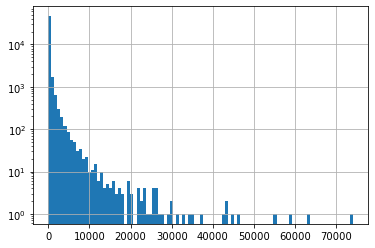

In [36]:
gu['ones'] = 1 # 횟수를 세기 위한 변수 -> gu['count'] 컬럼이 존재하므로 중복을 피하기 위해 이름을 다르게 설정
gu.groupby('product_id').agg({'ones':np.sum})['ones'].hist(bins=100, log=True)

# 파레토 분포 -> 극소수의 인기 상품, 잘 안 팔리는 물건이 대다수

In [37]:
gu.groupby('product_id').agg({'ones':np.sum}).sort_values(by='ones')[::-1].head()

,ones
product_id,
24852,73956
13176,63537
21137,58838
21903,55037
47626,46402


In [38]:
products.loc[products['product_id'] == 24852]

# product_name을 확인해보면 모두 과일/채소
# 상위 5개 상품 모두 department_id=4, aisle_id도 하나를 제외하면 24로 동일

,product_id,product_name,aisle_id,department_id
24851,24852,Banana,24,4


<AxesSubplot:>

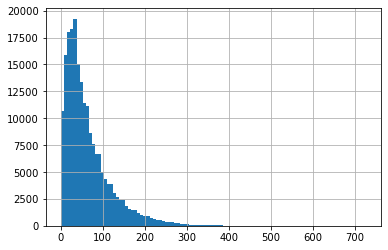

In [39]:
# user 기준
gu.groupby('user_id').agg({'ones':np.sum})['ones'].hist(bins=100)

#### 추가로 고민해볼 부분

In [40]:
# 1) 요일/시간에 따른 세부적인 추천
# others 데이터의 order_dow(요일), order_hour_of_day(시간)
# 평일(월~목)/주말(금~일)에 따라 다른 소비 패턴이 데이터에 반영되어 있을 것

# 2) 기존 고객/신규 고객에게 다른 상품을 추천
# user -> 기존 고객 + 신규 고객
# 기존 고객과 신규 고객에게 추천하고자 하는 상품이 다를 것

# 추천 시스템: 특정 기준을 가지고 줄 세우기 -> 다양한 추천의 연결고리/기준이 존재